In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

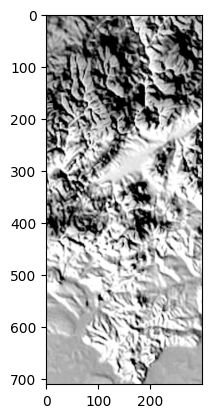

In [2]:
map = cv2.imread("map.png",0) #0 for greyscale,single channel
HEIGHT,WIDTH = map.shape
#Blur map
#map = cv2.GaussianBlur(map,(7,7), 0) # Kernel needs odd dimensions (11,11)
#print(map)
#plt.show()
plt.imshow(map, cmap='gray')
rx,ry,rtheta = (WIDTH/4,HEIGHT/4,0)

In [3]:
STEP = 5                 #variable is used later to control the robot's forward motion.
TURN = np.radians(25) #25 degrees converted to radians. This variable is used later to control the robot's turning motion.

def get_input(): #halt is initialized to False. This variable will be used to signal if the robot should stop moving.
    fwd = 0 # variable will be used to store the forward motion command.
    turn = 0 # variable will be used to store the turning motion command.
    halt = False #variable will be used to signal if the robot should stop moving.
    k = cv2.waitKey(0)#waits for a key and returns the ASCII code 
    if k == 82: #is the up arrow key (ASCII code 82), fwd variable is set to STEP robot to move forward by a distance of STEP units.
        fwd = STEP
    elif k == 83:#the right arrow key (ASCIIcode 83),the turn variable is set to TURN,robot to turn right by an angle of TURN radians.
        turn = TURN
    elif k == 81:
        turn = -Turn
    else:
        halt = True #halt variable is set to True, which will signal to the robot to stop moving.
    return fwd,turn,halt

### Read keyboard input.

In [4]:
SIGMA_STEP = 0.5
SIGMA_TURN = np.radians(5) # best way to control trackability for demo

def move_robot(rx, ry, rtheta, fwd, turn):
    # Re-orient and step robot, with noise
    fwd_noisy = fwd + np.random.normal(0.0, SIGMA_STEP, 1)
    rx += fwd_noisy * np.cos(rtheta)
    ry += fwd_noisy * np.sin(rtheta)
    print("fwd_noisy=", fwd_noisy)
    
    turn_noisy = turn + np.random.normal(0.0, SIGMA_TURN, 1)
    rtheta += turn_noisy
    print("turn_noisy=", np.degrees(turn_noisy))

    return rx, ry, rtheta
plt.show()

### Move the robot, with Gausssian noise.

![title](images/gaussian.png)

### Initialize particle cloud.

In [5]:
NUM_PARTICLES = 3000

def init():
    particles = np.random.rand(NUM_PARTICLES, 3)
    particles *= np.array( (WIDTH, HEIGHT, np.radians(360)) )
    return particles

################# Move the particles.############################

def move_particles(particles, fwd, turn):
    particles[:,0] += fwd * np.cos(particles[:,2])
    particles[:,1] += fwd * np.sin(particles[:,2])
    particles[:,2] += turn

    particles[:,0] = np.clip(particles[:,0], 0.0, WIDTH-1)
    particles[:,1] = np.clip(particles[:,1], 0.0, HEIGHT-1)
    return particles


In [6]:
#########Get value from robot's sensor.
def sense(x, y, noisy=False):
    SIGMA_SENSOR = 5
    x = int(x)
    y = int(y)
    if noisy:
        return map[y,x] + np.random.normal(0.0, SIGMA_SENSOR, 1)
    return map[y,x]

In [7]:
###########Compute particle weights.
def compute_weights(particles, robot_sensor):    
    errors = np.zeros(NUM_PARTICLES)
    for i in range(NUM_PARTICLES):
        particle_sensor = sense(particles[i,0], particles[i,1])
        errors[i] = abs(robot_sensor - particle_sensor)
    weights = np.max(errors) - errors

    # Kill off particles on edge
    weights[
        (particles[:,0] == 0) |
        (particles[:,0] == WIDTH-1) |
        (particles[:,1] == 0) |
        (particles[:,1] == HEIGHT-1)
    ] = 0.0

    # Increase sensitivity
    weights = weights ** 3
    return weights

In [8]:
########Resample the particles.
def resample(particles, weights):
    probabilities = weights / np.sum(weights)
    new_index = np.random.choice(
        NUM_PARTICLES,
        size=NUM_PARTICLES,
        p=probabilities
    )
    particles = particles[new_index,:]
    return particles

In [9]:
#############Add noise to the particles.
def add_noise(particles):
    SIGMA_PARTICLE_STEP = 2 #2
    SIGMA_PARTICLE_TURN = np.pi / 24 #np.pi / 24
    noise = np.concatenate((
        np.random.normal(0, SIGMA_PARTICLE_STEP, (NUM_PARTICLES,1)),
        np.random.normal(0, SIGMA_PARTICLE_STEP, (NUM_PARTICLES,1)),
        np.random.normal(0, SIGMA_PARTICLE_TURN, (NUM_PARTICLES,1)),
        ),
        axis=1
    )
    particles += noise
    return particles


In [10]:
############Display robot, particles and best guess.
def display(map, rx, ry, particles):
    lmap = cv2.cvtColor(map, cv2.COLOR_GRAY2BGR)
    
    # Display particles
    if len(particles) > 0 and False:
        for i in range(NUM_PARTICLES):
            cv2.circle(lmap, 
                       (int(particles[i,0]), int(particles[i,1])), 
                       1, 
                       (255,0,0), 
                       1)
        
    # Display robot
    cv2.circle(lmap, (int(rx), int(ry)), 5, (0,255,0), 10)

    # Display best guess
    if len(particles) > 0:
        px = np.mean(particles[:,0])
        py = np.mean(particles[:,1])
        cv2.circle(lmap, (int(px), int(py)), 5, (0,0,255), 5)

    cv2.imshow('map', lmap)

In [11]:
########## Main routine.

def init():
    return np.zeros((NUM_PARTICLES, 2))

particles = init()

while True:
    display(map, rx, ry, particles)
    fwd, turn, halt = get_input()
    if halt:
        break
    rx, ry, rtheta = move_robot(rx, ry, rtheta, fwd, turn)
    particles = move_particles(particles, fwd, turn)
    if fwd != 0:
        robot_sensor = sense(rx, ry, noisy=True)        
        weights = compute_weights(particles, robot_sensor)
        particles = resample(particles, weights)
        particles = add_noise(particles)
    
cv2.destroyAllWindows()  